In [45]:
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import datasets as hfds

from tqdm.notebook import tqdm
from utils import *

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(1234)

import numpy as np
np.random.seed(1234)

In [2]:
dataset = ChestXDataset(split="train")

Resolving data files:   0%|          | 0/35 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/35 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/31 [00:00<?, ?it/s]

In [33]:
dataset.pathology_names[8]

'Infiltration'

In [3]:
class PatholModel(nn.Module):
    def __init__(self):
        super().__init__()
        # self.model = ChestXPathologyModel.from_pretrained("BrachioLab/chestx_pathols")
        self.model = ChestXPathologyModel()
        self.pathol_idx = 8

    def forward(self, x):
        prob = self.model(x)[:,self.pathol_idx].view(-1,1) # Fibrosis is index 6
        # prob = (1 + prob)/2
        # prob = prob / 2
        return torch.cat([1-prob, prob], dim=-1)

In [4]:
def make_r1_pertbs(alpha):
    zero_inds = (alpha == 0).nonzero()
    pertbs = []
    for ind in zero_inds:
        alpha_p = alpha.clone()
        alpha_p[*ind] = 1
        pertbs.append(alpha_p)
    return torch.stack(pertbs)

In [5]:
def find_mismatched_r1_pertb(model, image, alpha):
    pertbs = make_r1_pertbs(alpha)
    pertbs_big = F.interpolate(pertbs.float().view(-1,1,7,7), (224,224))
    pertbs_out = model(image.view(1,1,224,224) * pertbs_big).argmax(dim=-1)
    return pertbs, pertbs_out

In [6]:
lambda_ = 0.5
raw_model = PatholModel().eval().to(device)
mus_model = CertifiedMuSImageClassifier(raw_model, lambda_=lambda_, quant=8)

In [7]:
pbar = tqdm(dataset)
all_hot_count = 0
for idx, item in enumerate(pbar):
    pbar.set_description(f"all_hot_count {all_hot_count}")
    image = item["image"].to(device)
    # Find something where the model claims the pathology exists
    raw_out = raw_model(image.view(1,1,224,224)).argmax(dim=-1)
    mus_out_ = mus_model(image.view(1,1,224,224))
    mus_out = mus_out_["logits"].argmax(dim=-1)
    
    if raw_out != 1 or mus_out != 1:
        continue

    # alpha = (torch.rand(7,7) < 0.25).long().to(device)
    alpha = get_lime_for_image(
        raw_model, image, torch.tensor([1]), num_patches=49, num_samples=100, top_k_frac=0.2 
    ).view(7,7)
    # alpha = get_shap_for_image(
    #     raw_model, image, torch.tensor([1]), num_patches=49, num_samples=100, top_k_frac=0.2
    # ).view(7,7)

    alpha_big = F.interpolate(alpha.float().view(1,1,7,7), (224,224))

    raw_alpha_out = raw_model(image * alpha_big).argmax(dim=-1)
    mus_alpha_out_ = mus_model(image * alpha_big)
    mus_alpha_out = mus_alpha_out_["logits"].argmax(dim=-1)

    if raw_alpha_out != 1 or mus_alpha_out != 1:
        continue

    if mus_alpha_out_["cert_rs"] < 1/(2*lambda_):
        continue

    pertbs, pertbs_out = find_mismatched_r1_pertb(raw_model, image, alpha)
    if (pertbs_out == 0).any():
        break
    else:
        all_hot_count += 1

  0%|          | 0/23094 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
image = image.view(224,224).cpu()
torchvision.utils.save_image(image, "images/image.png")

In [47]:
alpha_big = alpha_big.view(224,224).float().cpu()
torchvision.utils.save_image(alpha_big, "images/alpha.png")

In [48]:
torchvision.utils.save_image(image * alpha_big, "images/image_alpha.png")

In [44]:
bad_ind = (pertbs_out == 0).nonzero().squeeze().item()
alpha_bad = pertbs[bad_ind]
alpha_bad_big = F.interpolate(alpha_bad.view(1,1,7,7), (224,224)).view(224,224).float().cpu()

In [54]:
torchvision.utils.save_image(alpha_bad_big - alpha_big, "images/alpha_diff.png")
torchvision.utils.save_image(image * (alpha_bad_big - alpha_big), "images/image_alpha_diff.png")
torchvision.utils.save_image(alpha_bad_big, "images/alpha_bad.png")
torchvision.utils.save_image(image * alpha_bad_big, "images/image_alpha_bad.png")

In [55]:
rand_masks = (torch.rand(4,1,7,7) < 0.5).float()
rand_masks_big = F.interpolate(rand_masks.view(-1,1,7,7), (224,224)).view(-1,224,224).float()
for i, rmb in enumerate(rand_masks_big):
    torchvision.utils.save_image(image * rmb.squeeze(), f"images/image_randmask_{i}.png")

In [59]:
image_color = image.view(1,224,224).repeat(3,1,1)
image_color[1,alpha_big == 1] = 1
torchvision.utils.save_image(image_color, "images/image_alpha_color.png")

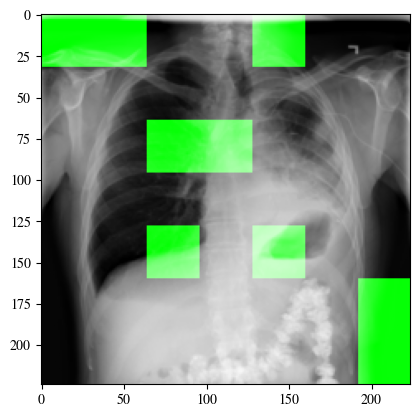

In [58]:
plt.clf()
plt.imshow(image_color.numpy().transpose(1,2,0))